In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", "all", "JJA", -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], None, None, None, reduce_da=True
)

exp_T = Experiment(
    "ERA5", "surf", "t", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)

da_T = exp_T.da


exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350])
all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds_uncat = exp.props_as_ds(False)
props_as_ds = exp.props_as_ds(True)
da = exp.ds["s"]

jet_pos_da = jet_position_as_da(da, props_as_ds_uncat, all_jets_one_df, exp.path)
props_as_ds["nao"] = get_nao(props_as_ds)
overlap = (jet_pos_da > 0).any("lat").all("jet")
props_as_ds["double_jet_index"] = overlap.sel(lon=slice(-20, None, None)).mean("lon")

In [3]:
metric = "euclidean"
nx = 6
ny = 4
ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
    ds = flatten_by(ds, "s")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    metric=metric,
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=50, start_learning_rate=0.05),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})
labels = xr.DataArray(labels, coords={"time": exp_s.samples_dims["time"]})

In [4]:
centers_all_jets = find_all_jets(ds_center.load(), processes=min(ds_center.cluster.shape[0], N_WORKERS), chunksize=1, jet_threshold=0.6e8, wind_threshold=22, alignment_threshold=0.3, mean_alignment_threshold=0.5, hole_size=0, smooth_s=1.0)
stuff = []
for t, jets in enumerate(centers_all_jets):
    for j, jet in enumerate(jets):
        x = np.arange(len(jet))
        y = np.gradient(jet["lev"]) * (1 - jet["alignment"] ** 2)
        crit = np.sum(np.clip(y, None, 0))
        minv = np.amin(y)
        wherepeak = np.argmin(y)
        wherepeak_rel = wherepeak / (len(y) - 1)
        if crit < -10 and minv < -.1 and wherepeak_rel > .1 and wherepeak_rel < 1:
            stuff.append((t, j, wherepeak))
for s in stuff:
    t, j, wherepeak = s
    jets = centers_all_jets[t].copy()
    jet = jets[j].copy()
    del jets[j]
    jets.extend([d.reset_index() for d in np.split(jet, [wherepeak], axis=0)])
    centers_all_jets[t] = jets
centers_all_jets_df = all_jets_to_one_df(centers_all_jets, time=np.arange(net.n_nodes), time_name="cluster")
centers_props_ds_uncat = compute_all_jet_props(centers_all_jets_df, centers, processes=min(ds_center.cluster.shape[0], N_WORKERS), chunksize=1)
centers_props_ds = categorize_ds_jets(centers_props_ds_uncat)

Finding all jets


100%|██████████| 24/24 [00:09<00:00,  2.51it/s]
/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapa

all jets to one df


100%|██████████| 24/24 [00:00<00:00, 594.84it/s]

Computing jet properties



100%|██████████| 24/24 [00:10<00:00,  2.25it/s]


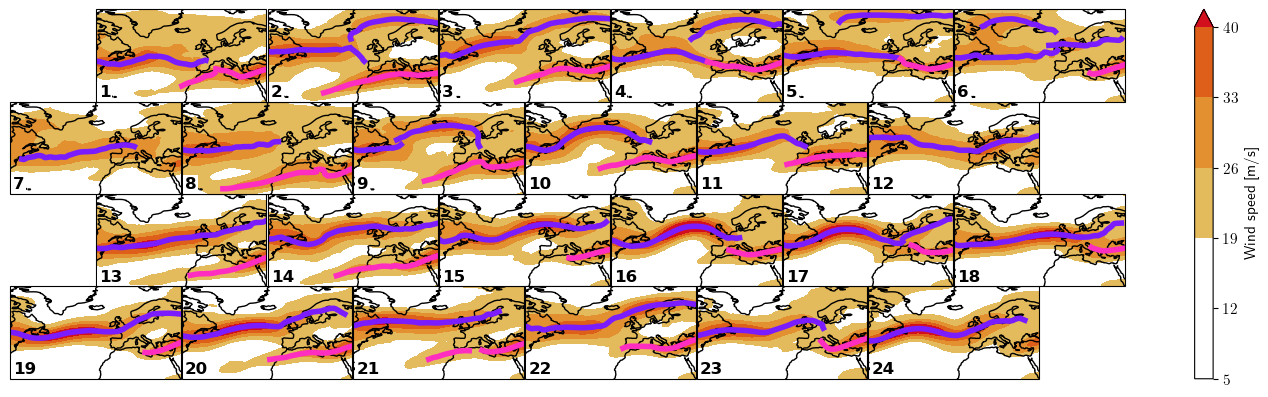

In [5]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True, numbering=True)
_ = clu.add_contourf(
    centers,
    cmap=colormaps.cet_l_wyor,
    transparify=2,
    nlevels=6,
    cbar_kwargs={"label": "Wind speed [m/s]"}
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS[2 - int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
plt.savefig(f'{FIGURES}/som_composites/wind.png')

100%|██████████| 24/24 [00:01<00:00, 21.64it/s]


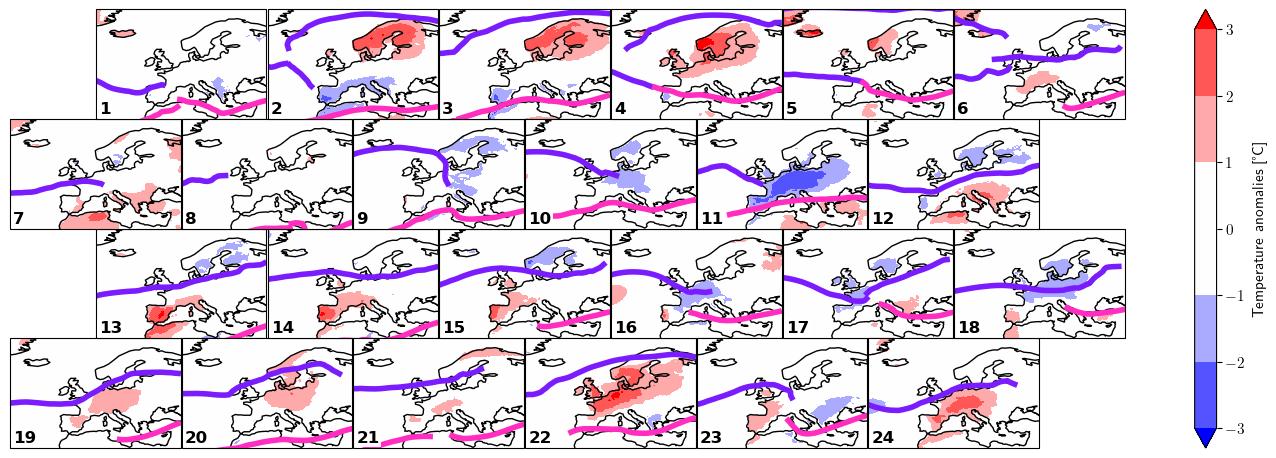

In [6]:
clu = Clusterplot(net.height, net.width, exp_T.region, honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_T, mask, "contourf", stippling=False, cbar_label="Temperature anomalies [°C]", cmap='bwr', q=0.999
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS[2 - int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
plt.savefig(f'{FIGURES}/som_composites/temp.png')

In [7]:
da_pvs = Experiment("ERA5", "surf", "pvs", "6H", "all", "JJA", *exp_s.region, 250, "hourofyear", {"hourofyear": ("win", 60)}).da
s_to_pvs = np.isin(labels.time.values, da_pvs.time.values)

100%|██████████| 24/24 [00:03<00:00,  6.10it/s]


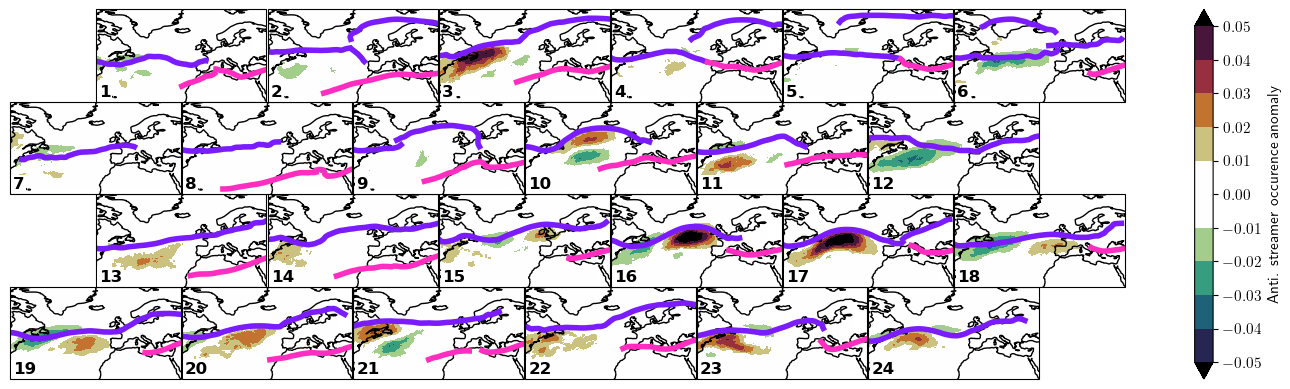

In [8]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_pvs.loc[:, 'anti'], mask[s_to_pvs], "contourf", stippling=False, cbar_label="Anti. streamer occurence anomaly", cmap=colormaps.seasons, q=0.998
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS[2 - int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
plt.savefig(f'{FIGURES}/som_composites/apvs.png')

100%|██████████| 24/24 [00:03<00:00,  6.04it/s]


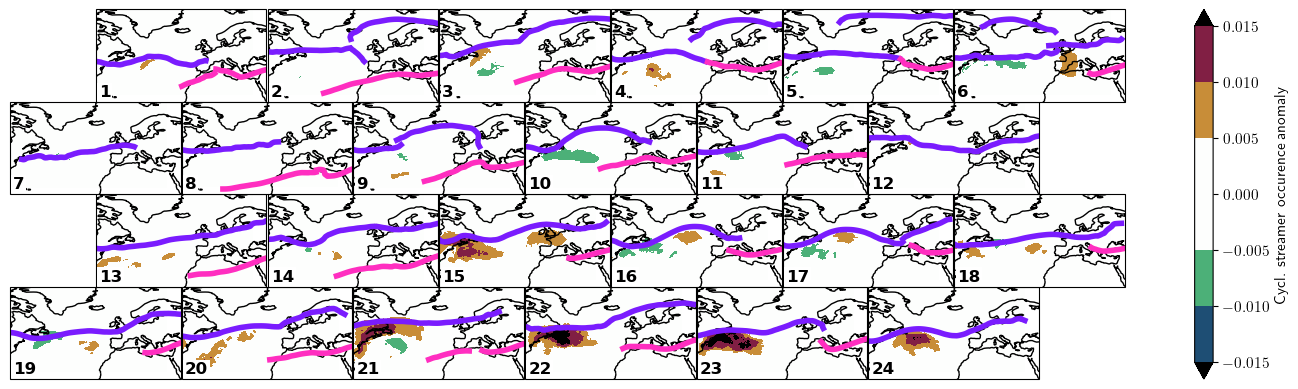

In [9]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_pvs.loc[:, 'cycl'], mask[s_to_pvs], "contourf", stippling=False, cbar_label="Cycl. streamer occurence anomaly", cmap=colormaps.seasons, q=0.997
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS[2 - int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
plt.savefig(f'{FIGURES}/som_composites/cpvs.png')

In [10]:
jet_pos_da = jet_position_as_da(da, props_as_ds_uncat, all_jets_one_df, exp.path)
jet_pos_da = coarsen_da(jet_pos_da, 1.5)
s_to_jp = np.isin(da.time.values, jet_pos_da.time.values)
jet_pos_da_summer = jet_pos_da.interp(time=da.time.values).sel(time=da.time.dt.season=="JJA")

100%|██████████| 24/24 [00:00<00:00, 55.42it/s]


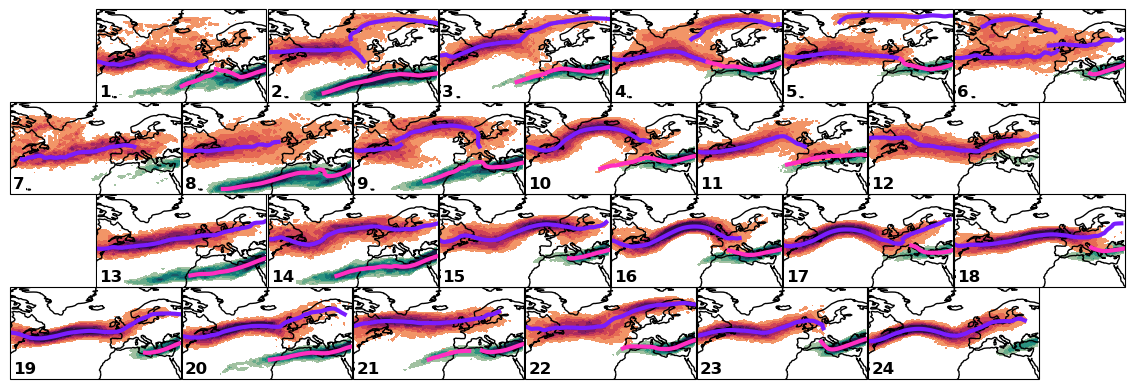

In [11]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
_ = clu.add_any_contour_from_mask(
    jet_pos_da_summer[:, 0] / jet_pos_da_summer[:, 0].max(), mask, cbar_label="Subtropical jet occurence", transparify=2, nlevels=9, cmap=colormaps.tempo, draw_cbar=False,
)
_ = clu.add_any_contour_from_mask(
    jet_pos_da_summer[:, 1] / jet_pos_da_summer[:, 1].max(), mask, cbar_label="Polar jet occurence", transparify=2, nlevels=9, cmap=colormaps.matter, draw_cbar=False,
)
for ax, jets, are_polar in zip(clu.axes, centers_all_jets, centers_props_ds_uncat["is_polar"].values):
    for j, (jet, is_polar) in enumerate(zip(jets, are_polar)):
        x, y, s = jet[["lon", "lat", "s"]].to_numpy().T
        ax.plot(x, y, color=COLORS[2 - int(is_polar)], ls="solid", lw=3)

clu.fig.set_size_inches(*(clu.fig.get_size_inches() * np.array([0.8, 1])))
clu.fig.savefig(f'{FIGURES}/som_composites/jet_pos.png')

In [12]:
exp_z = Experiment(
    "ERA5", "plev", "z", "6H", "all", "JJA", -80, 40, 15, 80, 500, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)

100%|██████████| 24/24 [00:02<00:00,  8.49it/s]


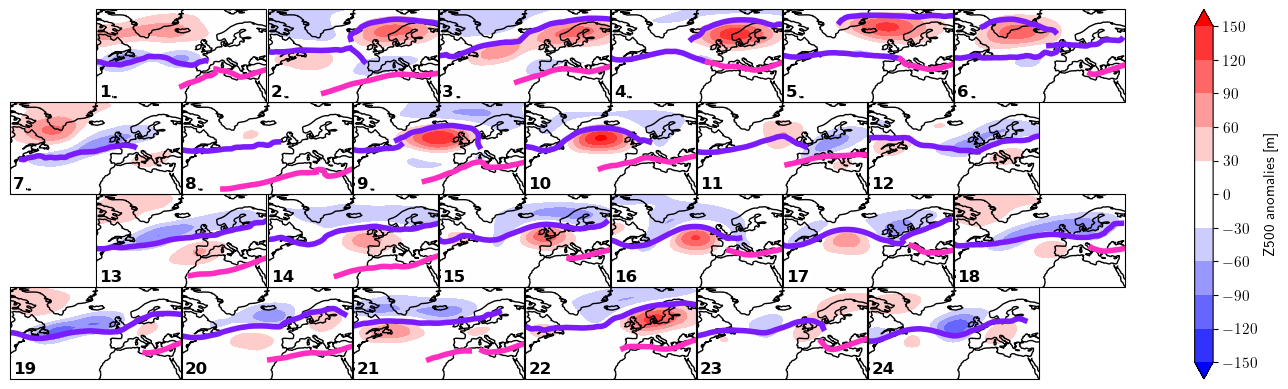

In [13]:
import scipy.constants as co
da_z = exp_z.da / co.g
clu = Clusterplot(net.height, net.width, exp_z.region, honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
clu.add_any_contour_from_mask(
    da_z, mask, "contourf", stippling=False, cbar_label="Z500 anomalies [m]", cmap='bwr', q=0.993, nlevels=6,
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS[2 - int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
plt.savefig(f'{FIGURES}/som_composites/z500.png')